In [1]:
%load_ext autoreload
%autoreload 2

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import poligrain as plg
import pykrige
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap

from mergeplg import merge

In [3]:
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

In [4]:
# ds_rad = ds_rad.isel(y=slice(None, None, -1))

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.longitudes, ds_rad.latitudes, ref_str
)

In [9]:
# This is not correct, but I have to quickly create a 1D array
# for x and y with the projection that has been used above
ds_rad["x"] = ds_rad.xs.isel(y=20)
ds_rad["y"] = ds_rad.ys.isel(x=20)

## Transform CML data from `xarray.Dataset` to `pandas.DataFrame`

In [10]:
df_cmls = ds_cmls.to_dataframe().swaplevel()
df_cmls["station_id"] = df_cmls.index.get_level_values(1)
df_cmls.index = df_cmls.index.droplevel(1)
df_cmls["sensor_type"] = "cml_ericsson"
df_cmls["rainfall_amount"] = df_cmls.R
df_cmls.head(3)

,sublink_id,site_0_lat,site_0_lon,site_1_lat,site_1_lon,frequency,polarization,length,quantile,R,site_0_x,site_0_y,site_1_x,site_1_y,x,y,station_id,sensor_type,rainfall_amount
time,,,,,,,,,,,,,,,,,,,
2015-07-25 12:30:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.081734,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.081734
2015-07-25 12:35:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.116602,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.116602
2015-07-25 12:40:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.153880,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.153880


In [11]:
from mergeplg import radolan

In [12]:
# x_grid, y_grid = np.meshgrid(ds_rad.x.values, ds_rad.y.values)

intersection_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_x.values,
    y1_line=ds_cmls.site_0_y.values,
    x2_line=ds_cmls.site_1_x.values,
    y2_line=ds_cmls.site_1_y.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.xs.data,
    y_grid=ds_rad.ys.data,
    grid_point_location="lower_left",
)

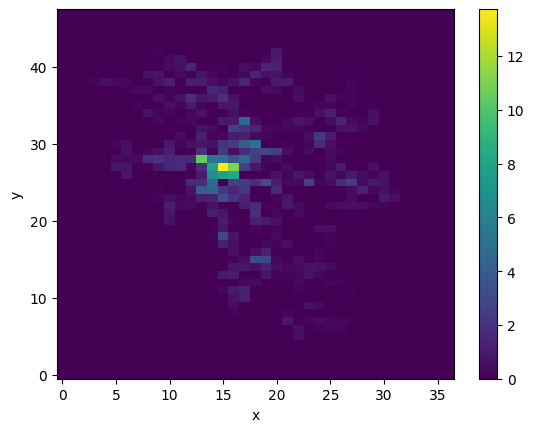

In [13]:
intersection_weights.sum(dim="cml_id").plot();

In [19]:
# need to set this variable since my old code starts with this
ds_rad["RH"] = ds_rad.rainfall_amount

In [131]:
ds_radolan_t_list = []
df_stations_t_list = []
for t in ds_rad.time.data:
    ds_radolan_t, df_stations_t = radolan.processing.rh_to_rw(
        ds_radolan_t=ds_rad.sel(time=t),
        df_stations_t=df_cmls.loc[t, :],
        allow_gauge_and_cml=True,
        intersect_weights=intersection_weights,
        max_distance=30e3,
    )
    ds_radolan_t_list.append(ds_radolan_t)
    df_stations_t_list.append(df_stations_t)

In [132]:
ds_radolan = xr.concat(ds_radolan_t_list, dim="time")
ds_radolan

<xarray.Dataset> Size: 9MB
Dimensions:                      (time: 31, y: 48, x: 37)
Coordinates:
  * time                         (time) datetime64[ns] 248B 2015-07-25T12:30:...
  * x                            (x) float64 296B 6.461e+05 ... 7.174e+05
  * y                            (y) float64 384B 6.346e+06 ... 6.439e+06
    xs                           (y, x) float64 14kB 6.457e+05 ... 7.157e+05
    ys                           (y, x) float64 14kB 6.343e+06 ... 6.441e+06
Data variables: (12/22)
    crs                          (time) int32 124B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    latitudes                    (time, y, x) float32 220kB 57.21 ... 58.06
    longitudes                   (time, y, x) float32 220kB 11.41 ... 12.66
    rainfall_amount              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RH                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    RG                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    ...                           ...
    mulfak_relevant              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW_not_rounded               (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW                           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
    RW_interim                   (time, y, x) float64 440kB 0.01078 ... 0.05403
    RR                           (time, y, x) float64 440kB nan nan ... nan nan
    RW_no_station_fill           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

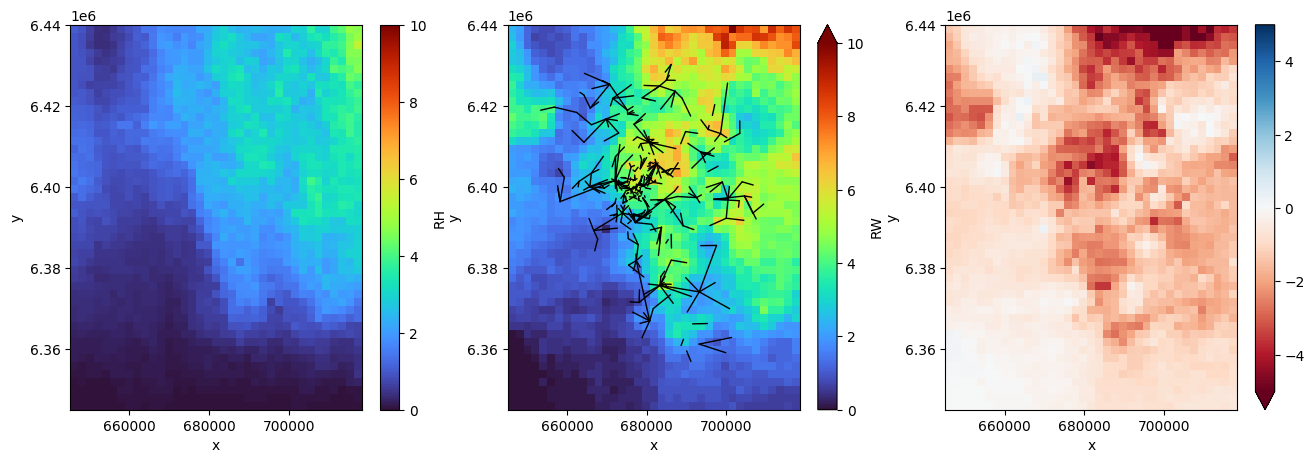

In [127]:
vmin, vmax = 0, 10
cmap = "turbo"
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ds_radolan.sum(dim="time").RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_radolan.sum(dim="time").RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
(ds_radolan.sum(dim="time").RH - ds_radolan.sum(dim="time").RW).plot(
    ax=axs[2],
    vmin=-5,
    vmax=5,
    cmap="RdBu",
)

plg.plot_map.scatter_lines(
    x0=ds_cmls.site_0_x,
    x1=ds_cmls.site_1_x,
    y0=ds_cmls.site_0_y,
    y1=ds_cmls.site_1_y,
    ax=axs[1],
    s=1,
    c="k",
)

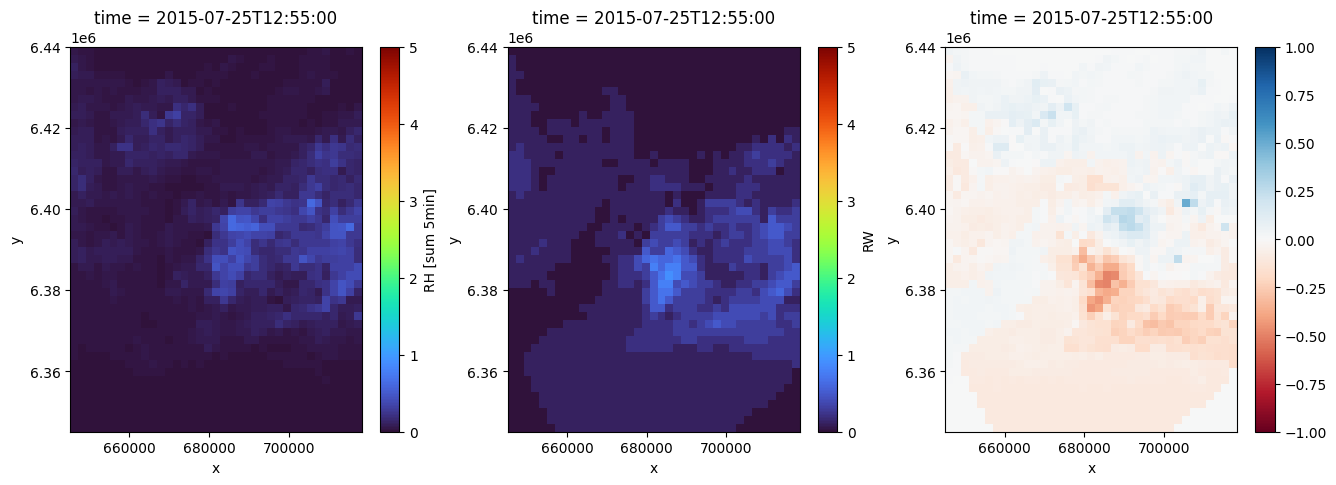

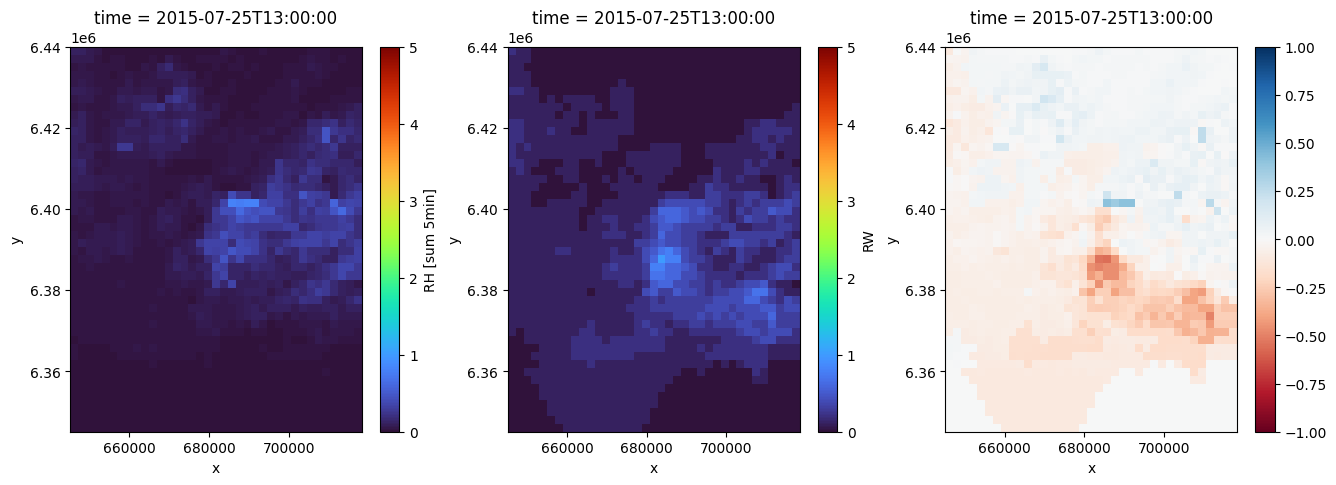

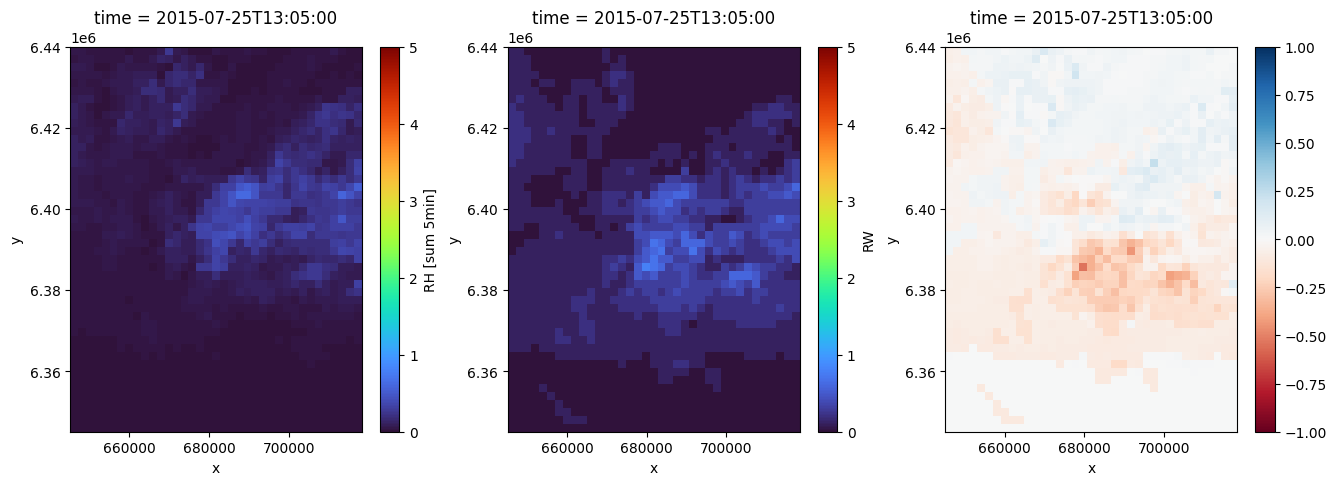

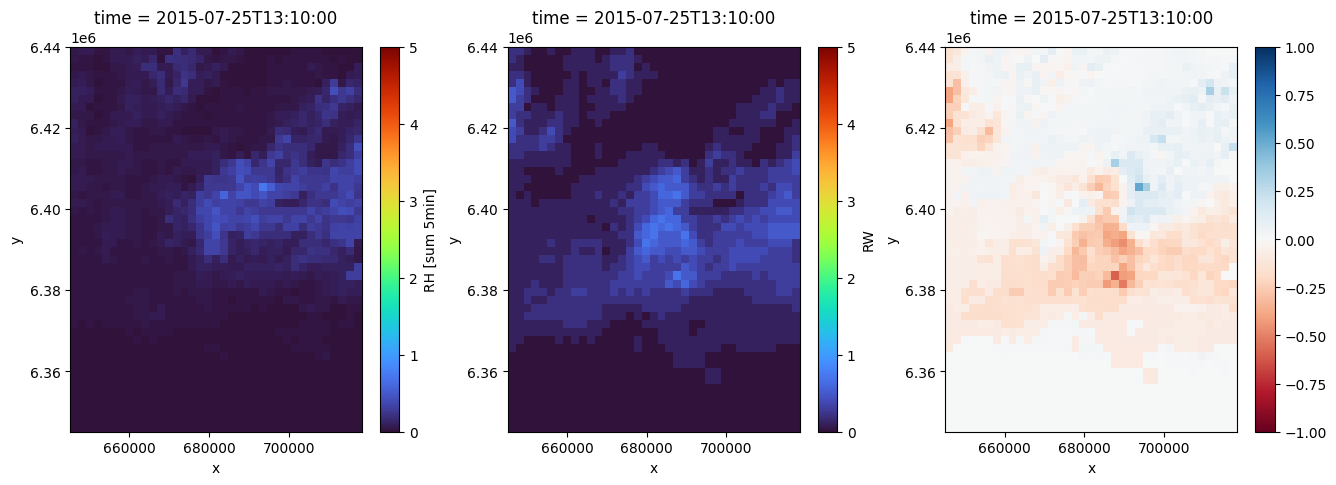

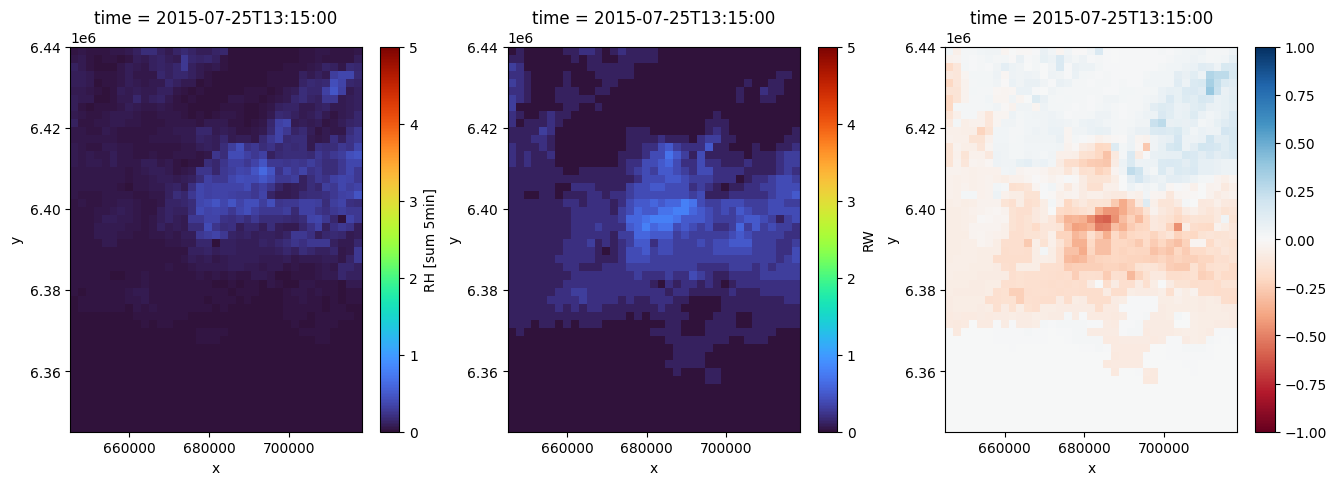

In [134]:
for t in ds_radolan.time.data[5:10]:
    vmin, vmax = 0, 5
    cmap = "turbo"
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    ds_radolan.sel(time=t).RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
    ds_radolan.sel(time=t).RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
    (ds_radolan.sel(time=t).RH - ds_radolan.sel(time=t).RW).plot(
        ax=axs[2],
        vmin=-1,
        vmax=1,
        cmap="RdBu",
    )

# Dev of tests

In [243]:
df_stations = pd.read_csv("../../tests/test_data/radolan_rain_gauge_data.csv")
df_stations = df_stations[616:1828]
df_stations = df_stations[~df_stations.station_id.str.contains("PL")]
# df_stations

<Axes: xlabel='x', ylabel='y'>

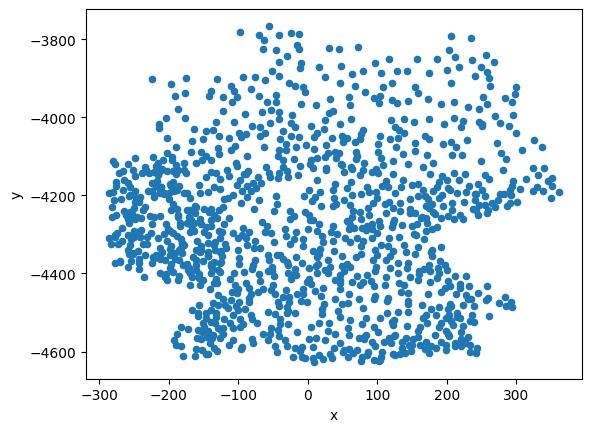

In [244]:
df_stations.plot.scatter("x", "y")

In [245]:
df_stations.to_csv("../../tests/test_data/radolan_rain_gauge_data_new.csv")

In [249]:
df_stations = pd.read_csv(
    "../../tests/test_data/radolan_rain_gauge_data_new.csv", index_col=1
)
df_stations

,Unnamed: 0,station_id,rainfall_amount,station_name,longitude,latitude,x,y
time,,,,,,,,
2021-08-23 09:50:00,616,A051,0.0,Weesby,9.148056,54.837222,-56.001728,-3766.004001
2021-08-23 09:50:00,617,A112,0.0,Wrixum/F�hr,8.527222,54.692778,-97.228436,-3781.664924
2021-08-23 09:50:00,618,A138,0.0,Bordelum,8.936944,54.632778,-70.310674,-3789.117674
2021-08-23 09:50:00,619,A159,0.0,Eggebek,9.365000,54.628333,-42.006186,-3790.045077
2021-08-23 09:50:00,620,A173,0.0,Satrup,9.626111,54.685278,-24.691174,-3783.690843
...,...,...,...,...,...,...,...,...
2021-08-23 09:50:00,1823,Q946,0.0,Gottmadingen,8.793333,47.734444,-96.754284,-4593.474468
2021-08-23 09:50:00,1824,Q978,0.0,Friedrichshafen-Unterraderach,9.440833,47.684444,-44.896512,-4600.236678
2021-08-23 09:50:00,1825,Q982,0.0,"Ki�legg, Kr. Ravensburg",9.886944,47.777778,-9.055617,-4589.318609


In [373]:
ds_radolan = xr.open_dataset("../../tests/test_data/radolan_ry_data.nc")

In [379]:
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

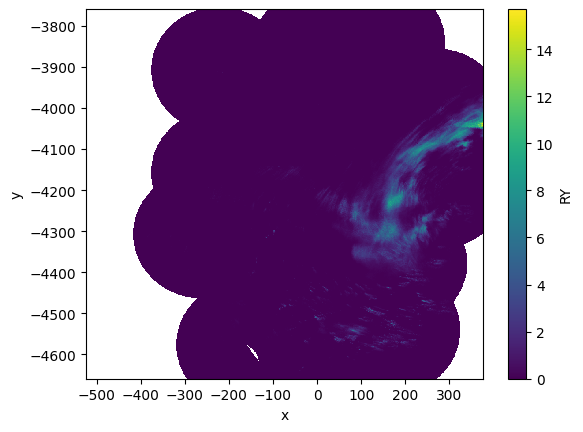

In [381]:
RY_sum.plot()

## test check radar coverage

In [269]:
import mergeplg as mrg

# ds_radolan, df_stations = get_test_data()
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

no_radar_coverage = mrg.radolan.adjust.check_for_radar_coverage(
    x_gage=[-1500, -350, -350, 100],
    y_gage=[-4500, -4500, -4300, -4300],
    x_radar=RY_sum.x.values.flatten(),
    y_radar=RY_sum.y.values.flatten(),
    no_radar_coverage_grid=RY_sum.isnull().values,  # noqa: PD003
)

np.testing.assert_equal(
    no_radar_coverage,
    np.array([True, True, False, False]),
)

## test label interim

In [316]:
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

df_stations_with_audit_interim = (
    mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
        df_gageset_t=df_stations,
        da_radolan=RY_sum,
        start_index_in_relevant=2,
    )
)

assert df_stations_with_audit_interim.audit.sum() == 228
assert df_stations_with_audit_interim.interim.sum() == 914
assert (
    df_stations_with_audit_interim[
        df_stations_with_audit_interim.audit
    ].station_id.iloc[101]
    == "L521"
)

# Test with random start index
audit_station_id_previous = None
N_random_runs = 5
for i in range(N_random_runs):
    # Note that the defaul for start_index_in_relevant='random', hence we do not set it here
    df_stations_with_audit_interim = (
        mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
            df_gageset_t=df_stations,
            da_radolan=RY_sum,
        )
    )
    audit_station_id = df_stations_with_audit_interim[
        df_stations_with_audit_interim.audit
    ].station_id.iloc[99]

    if audit_station_id_previous is None:
        audit_station_id_previous = audit_station_id
        continue
    elif audit_station_id != audit_station_id_previous:
        break
    else:
        audit_station_id_previous = audit_station_id
        continue
# This fails if all runs with random start index produced the same station_id
assert i < N_random_runs - 1


with pytest.raises(TypeError):
    mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
        df_gageset_t=df_stations,
        da_radolan=RY_sum,
        start_index_in_relevant=1.42,
    )

<Axes: xlabel='x', ylabel='y'>

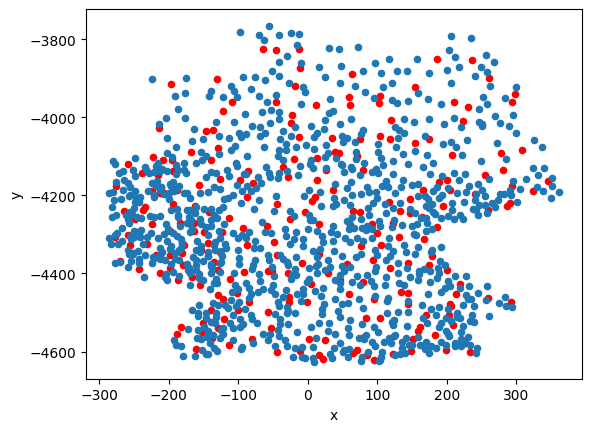

In [287]:
fig, ax = plt.subplots()

df_stations_with_audit_interim[
    df_stations_with_audit_interim.audit == True
].plot.scatter("x", "y", color="r", ax=ax)
df_stations_with_audit_interim[
    df_stations_with_audit_interim.interim == True
].plot.scatter("x", "y", ax=ax)

In [288]:
df_stations_with_audit_interim.audit.sum()

np.int64(228)

In [289]:
df_stations_with_audit_interim.interim.sum()

np.int64(914)

In [290]:
len(df_stations_with_audit_interim)

1142

In [296]:
df_stations_with_audit_interim[df_stations_with_audit_interim.audit].station_id.iloc[
    101
]

'L521'

## test get grid rainfall at points

In [339]:
df_stations["radar_at_gauge"] = mrg.radolan.adjust.get_grid_rainfall_at_points(
    RY_sum,
    df_stations,
)
np.testing.assert_array_almost_equal(
    df_stations.sort_values("radar_at_gauge").radar_at_gauge.values[-10:],
    np.array([4.69, 4.75, 4.76, 4.89, 5.73, 5.99, 6.39, 7.3, 7.57, 7.57]),
)
np.testing.assert_array_equal(
    df_stations.sort_values("radar_at_gauge").station_id.values[-5:],
    np.array(["O980", "O811", "M500", "F598", "O708"], dtype=object),
)

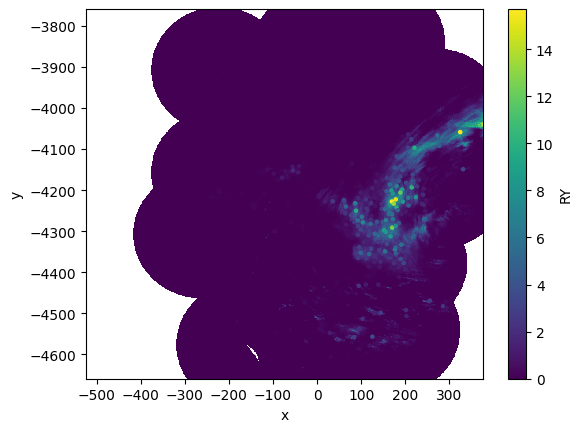

In [325]:
RY_sum.plot()
plt.scatter(
    df_stations.x,
    df_stations.y,
    c=df_stations.radar_at_gauge,
    s=5,
)

In [334]:
df_stations.sort_values("radar_at_gauge").station_id.values[-5:]

array(['O980', 'O811', 'M500', 'F598', 'O708'], dtype=object)

## test interpolate station values

In [367]:
interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="standard",
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[410:414, 710:714],
    np.array(
        [
            [2.72487096, 2.800001, 2.83147212, 2.82727883],
            [2.80509236, 2.88496315, 2.92157422, 2.92241554],
            [2.94312663, 3.00469669, 3.03208744, 3.02933747],
            [3.13244699, 3.15721331, 3.16299551, 3.14901499],
        ]
    ),
)

interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="radolan",
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[410:414, 710:714],
    np.array(
        [
            [2.68921691, 2.6993467, 2.67471823, 2.61990556],
            [2.78720804, 2.8033063, 2.78501507, 2.73558897],
            [2.93226004, 2.93803843, 2.91615941, 2.86679836],
            [3.12492011, 3.10614845, 3.07118028, 3.01634675],
        ]
    ),
)

# test filling of NaNs (first check that NaNs are there and then do interpolation
# again with filled NaNs)
nan = np.nan
np.testing.assert_array_almost_equal(
    interpolated_grid.values[355:359, 800:804],
    np.array(
        [
            [nan, nan, nan, nan],
            [1.02, 1.02, nan, nan],
            [1.23399745, 1.02, 1.02, 1.02],
            [1.23115475, 1.22518546, 1.21935005, 1.02],
        ]
    ),
)

interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="radolan",
    fill_value=0,
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[355:359, 800:804],
    np.array(
        [
            [0, 0, 0, 0.0],
            [1.02, 1.02, 0, 0],
            [1.23399745, 1.02, 1.02, 1.02],
            [1.23115475, 1.22518546, 1.21935005, 1.02],
        ]
    ),
)

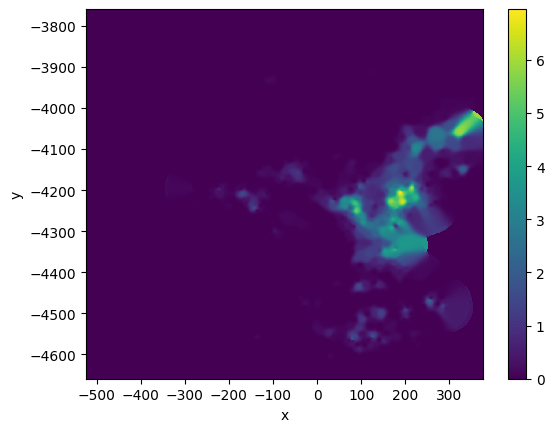

In [363]:
interpolated_grid.plot()

In [360]:
interpolated_grid[355:359, 800:804]

<xarray.DataArray (y: 4, x: 4)> Size: 128B
array([[       nan,        nan,        nan,        nan],
       [1.02      , 1.02      ,        nan,        nan],
       [1.23399745, 1.02      , 1.02      , 1.02      ],
       [1.23115475, 1.22518546, 1.21935005, 1.02      ]])
Coordinates:
  * y        (y) float64 32B -4.304e+03 -4.303e+03 -4.302e+03 -4.301e+03
  * x        (x) float64 32B 276.5 277.5 278.5 279.5

## test BOGRA

In [370]:
# Test with xarray.DataArray
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(RY_sum)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, -0.03349609],
            [0.0, -1.08796875, 0.0],
            [-0.2034375, -0.99517578, 0.0],
            [0.0, 0.0, -0.32083984],
        ],
    ),
)

# Test again, but with different threshold
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(
    RY_sum,
    max_allowed_relative_diff=5,
)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, 0.0],
            [0.0, -0.98375, 0.0],
            [0.0, -0.83375, 0.0],
            [0.0, 0.0, 0.0],
        ],
    ),
)

# Test again, but with high threshold and less iterations, just to check
# that the `break` in the bogra loop is called.
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(
    RY_sum, max_allowed_relative_diff=10, max_iterations=10
)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, 0.0],
            [0.0, 0, 0.0],
            [0.0, 0, 0.0],
            [0.0, 0.0, 0.0],
        ],
    ),
)

# Test that resutls are the same for numpy array xarray.DataArray as input
np.testing.assert_array_almost_equal(
    mrg.radolan.adjust.bogra_like_smoothing(RY_sum).values,
    mrg.radolan.adjust.bogra_like_smoothing(RY_sum.values),
)

# Continue with example notebook...

In [143]:
ds_rad.coords["lon"] = ds_rad.longitudes
ds_rad.coords["lat"] = ds_rad.latitudes

grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
    nnear=1,
)

In [148]:
ds_gauges.coords["id"] = ds_gauges.station_id

In [151]:
radar_at_gauges = grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,
)

RW_at_gauges = grid_at_points(
    da_gridded_data=ds_radolan.RW_not_rounded,
    da_point_data=ds_gauges.rainfall_amount,
)

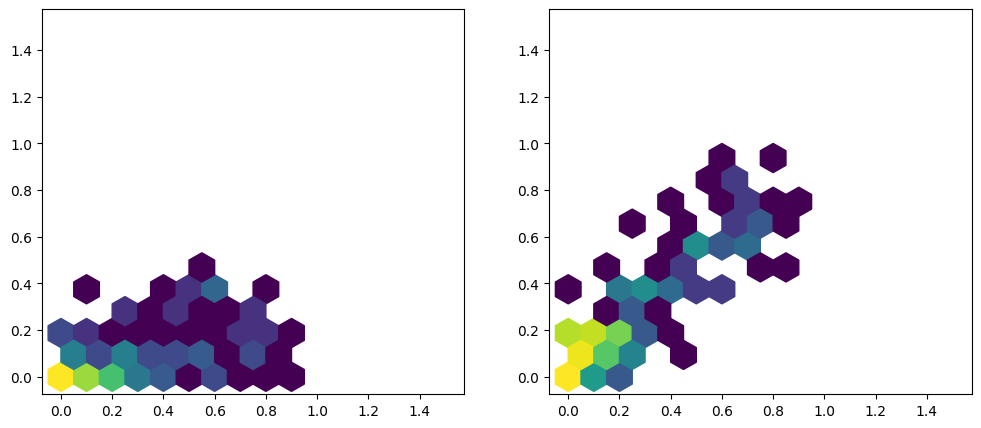

In [173]:
extent = [0, 1.5, 0, 1.5]
gridsize = 15

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hexbin(
    ds_gauges.rainfall_amount,
    radar_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
)

axs[1].hexbin(
    ds_gauges.rainfall_amount,
    RW_at_gauges,
    mincnt=1,
    extent=extent,
    gridsize=gridsize,
    bins="log",
)

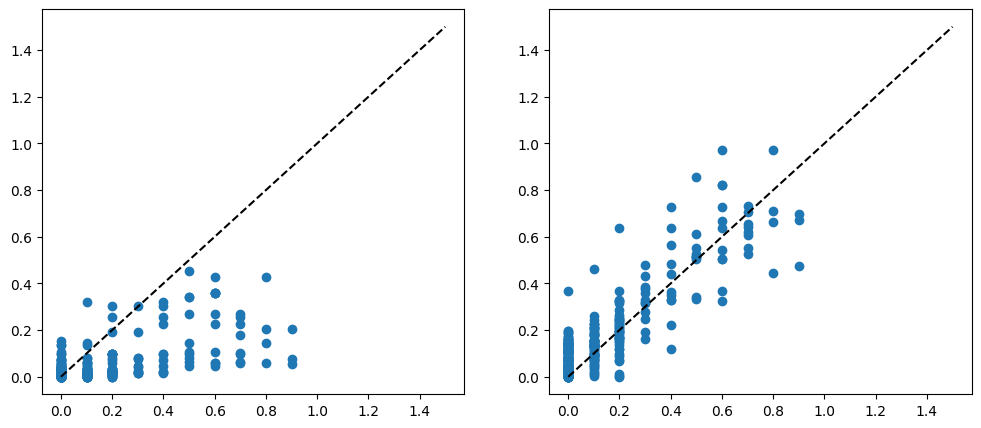

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(
    ds_gauges.rainfall_amount,
    radar_at_gauges,
)

axs[1].scatter(
    ds_gauges.rainfall_amount,
    RW_at_gauges,
)

axs[0].plot([0, 1.5], [0, 1.5], "k--")
axs[1].plot([0, 1.5], [0, 1.5], "k--")

In [190]:
np.corrcoef(ds_gauges.rainfall_amount.data.flatten(), radar_at_gauges.data.flatten())[
    0, 1
]

np.float64(0.6258268572801465)

In [186]:
np.corrcoef(ds_gauges.rainfall_amount.data.flatten(), RW_at_gauges.data.flatten())[0, 1]

np.float64(0.869102370031439)

In [191]:
np.sqrt(
    np.mean(
        (ds_gauges.rainfall_amount.data.flatten() - RW_at_gauges.data.flatten()) ** 2
    )
)

np.float64(0.11261985113237322)

## Calculate radar along CMLs (could be moved to merging functions)

In [4]:
# Delay grids to allow dask to track them
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.longitudes.data,
    y_grid=ds_rad.latitudes.data,
    grid_point_location="center",  # dont know hat reference are used
)

In [5]:
start = ds_rad.time[0].data
end = ds_rad.time[-1].data

grid_data = ds_rad.sel(time=slice(start, end)).rainfall_amount
ds_cmls["R_rad"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=grid_data,
    intersect_weights=intersect_weights,
)

In [6]:
# Remove outlier CMLs (KED is sensitive to ouliers)
keep = np.where(
    ds_cmls.R.mean(dim="time") < np.quantile(ds_cmls.R.mean(dim="time"), q=0.95)
)[0]
ds_cmls = ds_cmls.isel(cml_id=keep)

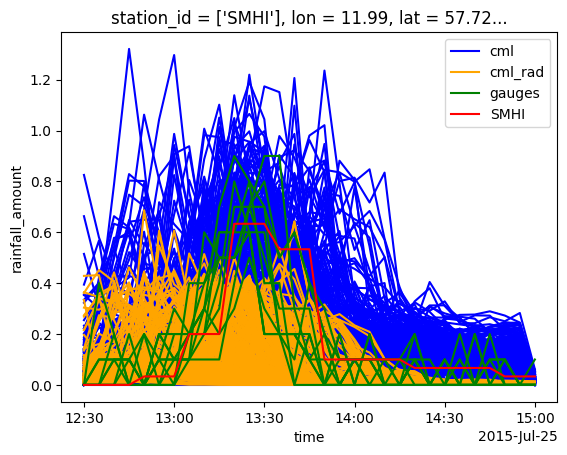

In [7]:
ds_cmls.R.plot.line(x="time", add_legend=False, color="blue")
ds_cmls.R.isel(cml_id=0).plot.line(
    x="time", add_legend=False, color="blue", label="cml"
)

ds_cmls.R_rad.plot.line(x="time", add_legend=False, color="orange")
ds_cmls.R_rad.isel(cml_id=0).plot.line(
    x="time", add_legend=False, color="orange", label="cml_rad"
)

ds_gauges.rainfall_amount.plot.line(x="time", add_legend=False, color="green")
ds_gauges.isel(station_id=0).rainfall_amount.plot.line(
    x="time", add_legend=False, color="green", label="gauges"
)

ds_gauges_smhi.rainfall_amount.plot.line(
    x="time", add_legend=False, color="red", label="SMHI"
)


plt.legend()

# Define new grid for radar merging (optional)

In [12]:
# define xgrid and ygrid for estimating rainfall
gridsize = 200
xgrid = np.arange(
    np.floor(ds_cmls.site_0_x.min().data.astype(int) / 1000) * 1000,
    np.ceil(ds_cmls.site_0_x.max().data.astype(int) / 1000) * 1000,
    gridsize,
)
ygrid = np.arange(
    np.floor(ds_cmls.site_0_y.min().data.astype(int) / 1000) * 1000,
    np.ceil(ds_cmls.site_0_y.max().data.astype(int) / 1000) * 1000,
    gridsize,
)
xx, yy = np.meshgrid(xgrid, ygrid)

In [13]:
# projected radar, using nearest neighbour lookup
rad_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])
cml_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])

# numpy array for fast lookup
rad = ds_rad.rainfall_amount.data
cml = ds_cmls.R.data
xs = ds_rad.xs.data
ys = ds_rad.ys.data
x = ds_cmls.x.data
y = ds_cmls.y.data

for y_ind in range(ygrid.size):
    for x_ind in range(xgrid.size):
        # compute distances to all radar points
        distances = (xs - xgrid[x_ind]) ** 2 + (ys - ygrid[y_ind]) ** 2

        # find position of closes point in grid
        index = np.argmin(distances)
        y_rad_ind, x_rad_ind = np.unravel_index(index, distances.shape)

        # compute distances to all CML midpoints (simple nearest neighbour method)
        distances = (x - xgrid[x_ind]) ** 2 + (y - ygrid[y_ind]) ** 2

        # CML
        cml_i = np.argmin(distances)

        for t in range(ds_rad.time.size):
            # get closest radar value for this point
            rad_imgs[t, y_ind, x_ind] = rad[t, y_rad_ind, x_rad_ind]

            # get closest cml value for this point
            cml_imgs[t, y_ind, x_ind] = cml[t, cml_i]

ds_rad_proj = xr.Dataset(
    data_vars={
        "rainfall_amount": (["time", "y", "x"], rad_imgs),
        "cml_nearest": (
            ["time", "y", "x"],
            cml_imgs,
        ),
    },
    coords={"time": ds_rad.time, "y": ygrid, "x": xgrid},
)

In [14]:
# Store grid
ds_rad_proj = ds_rad_proj.assign_coords(
    {
        "xs": (("y", "x"), np.meshgrid(ds_rad_proj.x, ds_rad_proj.y)[0]),
        "ys": (("y", "x"), np.meshgrid(ds_rad_proj.x, ds_rad_proj.y)[1]),
    }
)

In [15]:
# Remove low rainfall values
thrshld = 0.1  # sum 5 min, quite large tho, but measurable etc..
ds_rad_proj["rainfall_amount"] = xr.where(
    ds_rad_proj.rainfall_amount > thrshld, ds_rad_proj.rainfall_amount, 0
)
ds_cmls["R"] = xr.where(thrshld < ds_cmls.R, ds_cmls.R, 0)
ds_cmls["R_rad"] = xr.where(ds_cmls.R_rad > thrshld, ds_cmls.R_rad, 0)

# Case

In [16]:
min_obs = 5

## Additive using IDW

In [17]:
# Set midpoint of CMLs
ds_cmls = ds_cmls.assign_coords(
    x=("cml_id", ((ds_cmls["site_0_x"] + ds_cmls["site_1_x"]) / 2).data)
)
ds_cmls = ds_cmls.assign_coords(
    y=("cml_id", ((ds_cmls["site_0_y"] + ds_cmls["site_1_y"]) / 2).data)
)

# Note: Current code uses np.nan to ignore observations inside the merging functions. For readability we could use another variable where we keep the reliability of the observations

In [18]:
# Calculate the difference between CML and radar,
# only use observations where both CML and radar measure rainfall
ds_cmls["R_diff"] = xr.where(
    (ds_cmls.R_rad > 0) & (ds_cmls.R > 0), ds_cmls.R - ds_cmls.R_rad, np.nan
)

In [19]:
data = []
for t, time in enumerate(ds_cmls.time.data):
    # perform block kriging on the difference data
    field = merge.merge_additive_idw(
        ds_cmls.R_diff.isel(time=t),
        ds_rad_proj.rainfall_amount.isel(time=t),
        where_rad=True,  # skip cells where the radar does not observe anything
        min_obs=min_obs,  # minimum number of observations needed to perform adjustment
    )

    # add the time coordinate
    field.coords["time"] = time

    # store adjusted fields
    data.append(field)

ds_rad_proj["rain_additive_idw"] = xr.concat(data, dim="time")

## Additive using Block Kriging

### Attempt to automatically estimate variogram (exponential) parameters using CML midpoint data

In [20]:
# Calculate the difference between CML and radar,
# only use observations where both CML and radar measure rainfall
ds_cmls["R_diff"] = xr.where(
    (ds_cmls.R_rad > 0) & (ds_cmls.R > 0), ds_cmls.R - ds_cmls.R_rad, np.nan
)

In [21]:
T = 0  # Number of neighbouring timesteps to include
drop_zero = True

# Calculate CML midpoint
x_ = ((ds_cmls.site_0_x + ds_cmls.site_1_x) / 2).data
y_ = ((ds_cmls.site_0_y + ds_cmls.site_1_y) / 2).data
kriging_param = {}

# Timestep to estimate parameters for variogram and transformation
for time_mid in range(ds_cmls.time.size):
    x, y, values = [], [], []

    # Set lower and upper timesteps
    lower = time_mid - T
    if lower < 0:
        lower = 0
    upper = time_mid + T + 1
    if upper > ds_cmls.time.size:
        upper = ds_cmls.time.size

    # Timesteps in window
    for time in ds_cmls.time[lower:upper]:
        val_ = ds_cmls.R_diff.sel(time=time).data

        # Drop zero values if drop_zero
        keep = (val_ > 0) if drop_zero else np.full(val_.shape, True)

        values.append(val_[keep])
        x.append(x_[keep])
        y.append(y_[keep])

    # turn lists to numpy
    x = np.concatenate(x)
    y = np.concatenate(y)
    values = np.concatenate(values)

    # Estimate variogram if enough observations
    if x.size >= min_obs:
        # coord = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])
        # V1 = skg.Variogram(
        #     coord,
        #     values,
        #     normalize=False,
        #     n_lags=8,
        #     use_nugget=True,
        #     model='exponential'
        # )

        ok = pykrige.OrdinaryKriging(
            x,
            y,
            values,
            variogram_model="exponential",
            # enable_plotting=True
        )

        sill, hr, nugget = ok.variogram_model_parameters
        # hr, sill, nugget = np.array(V1.parameters).ravel()

        kriging_param[ds_cmls.time.data[time_mid]] = [sill, hr, nugget]

    else:
        kriging_param[ds_cmls.time.data[time_mid]] = [np.nan, np.nan, np.nan]

kriging_param = pd.DataFrame.from_dict(
    kriging_param, orient="index", columns=["sill", "hr", "nugget"]
)

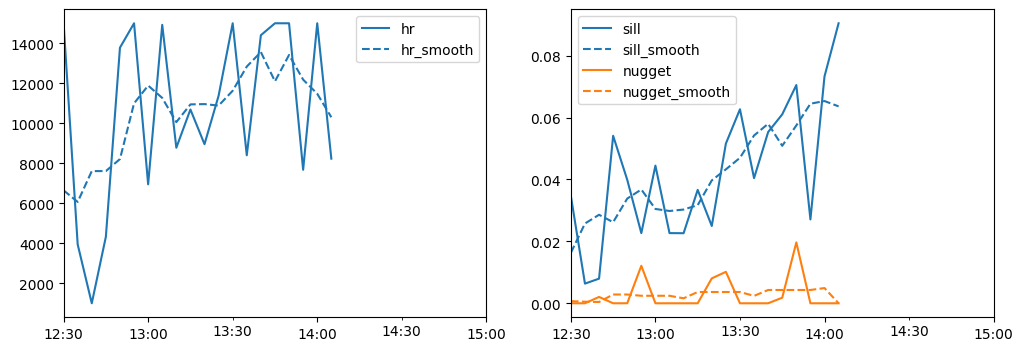

In [22]:
# Set hr minimum and maximum
hr_min = 1000
hr_max = 15000
kriging_param["hr"] = kriging_param["hr"].where(
    (kriging_param["hr"] > hr_min) | np.isnan(kriging_param["hr"]), hr_min
)
kriging_param["hr"] = kriging_param["hr"].where(
    (kriging_param["hr"] < hr_max) | np.isnan(kriging_param["hr"]), hr_max
)

# Use rolling window to process kriging parameters
n_rolling = 5

# Example smooth hr
kriging_param["hr_smooth"] = (
    kriging_param["hr"].rolling(n_rolling, min_periods=1, center=True).mean()
)
kriging_param["hr_smooth"] = kriging_param["hr_smooth"].where(
    ~np.isnan(kriging_param["hr"])
)

# Example smooth sill
kriging_param["sill_smooth"] = (
    kriging_param["sill"].rolling(n_rolling, min_periods=1, center=True).mean()
)
kriging_param["sill_smooth"] = kriging_param["sill_smooth"].where(
    ~np.isnan(kriging_param["sill"])
)

# Example smooth nugget
kriging_param["nugget_smooth"] = (
    kriging_param["nugget"].rolling(n_rolling, min_periods=1, center=True).mean()
)
kriging_param["nugget_smooth"] = kriging_param["nugget_smooth"].where(
    ~np.isnan(kriging_param["nugget"])
)

# Set large nugget values to 90% of sill
kriging_param["nugget_smooth"] = kriging_param["nugget_smooth"].where(
    kriging_param["nugget_smooth"] < kriging_param["sill_smooth"] * 0.9,
    other=kriging_param["sill_smooth"] * 0.9,
)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
kriging_param["hr"].plot(ax=ax[0], color="C0")
kriging_param["hr_smooth"].plot(ax=ax[0], color="C0", style="--")
ax[0].legend(["hr", "hr_smooth"])

kriging_param["sill"].plot(ax=ax[1], color="C0", style="-")
kriging_param["sill_smooth"].plot(ax=ax[1], color="C0", style="--")

kriging_param["nugget"].plot(ax=ax[1], color="C1", style="-")
kriging_param["nugget_smooth"].plot(ax=ax[1], color="C1", style="--")

ax[1].legend(["sill", "sill_smooth", "nugget", "nugget_smooth"])

# use smoothed parameters
kriging_param["hr"] = kriging_param["hr_smooth"]
kriging_param["sill"] = kriging_param["sill_smooth"]
kriging_param["nugget"] = kriging_param["nugget_smooth"]

### Merge

In [23]:
# Calculate position along all CMLs
x0 = merge.calculate_cml_geometry(ds_cmls, disc=9)

In [24]:
# Create function for creating variograms
def make_variogram(nugget, sill, hr):
    """Make a exponential variogram.

    Given nugget, sill and hr this function creates a expoenential variogram
    that can be used by the block kriging function.

    Parameters
    ----------
    nugget: float
        The nugget of the variogram. Can be used to introduce observation
        uncertianty into the kriging equations.
    sill: float
        The variance between two observations that are far apart.
    hr: float
        The range of the variogram, a measure on how fast the expected variability
        between two locations changes with distance.

    Returns
    -------
    variogram_: fucntion
        A function that computes the expected variance given the distance h.

    """

    def variogram_(h):  # Exponential variogram
        return nugget + (sill - nugget) * (1 - np.exp(-h * 3 / hr))

    return variogram_

In [25]:
data = []
for t, time in enumerate(ds_cmls.time.data):
    # Usage:
    nugget = kriging_param.loc[time]["nugget"]
    sill = kriging_param.loc[time]["sill"]
    hr = kriging_param.loc[time]["hr"]

    variogram = make_variogram(nugget, sill, hr)

    # If hr is nan, use radar instead
    if not np.isnan(hr):
        # perform block kriging on the difference data
        field = merge.merge_additive_blockkriging(
            ds_cmls.R_diff.isel(time=t),  # Difference CML and radar
            ds_rad_proj.rainfall_amount.isel(time=t),  # Radar field
            x0,  # CML geometry
            variogram,  # Variogram
            where_rad=True,  # Interpolate where radar has observations
            min_obs=min_obs,  # Number of observations needed for interpolation
        )

        # add the time coordinate
        field.coords["time"] = time

    else:
        field = ds_rad_proj.rainfall_amount.isel(time=[t])

    # store adjusted fields
    data.append(field)

ds_rad_proj["rain_additive_blockkriging"] = xr.concat(data, dim="time")

# Plot maps

In [26]:
cmap_colors = [
    (0, (0, 0, 0, 0)),  # transparent
    (0.01, (0, 0, 0, 0)),
    (0.01, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue

cmap_colors = [
    (0, "white"),
    # (0, 'white'),
    (0, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

2015-07-25T12:30:00.000000000


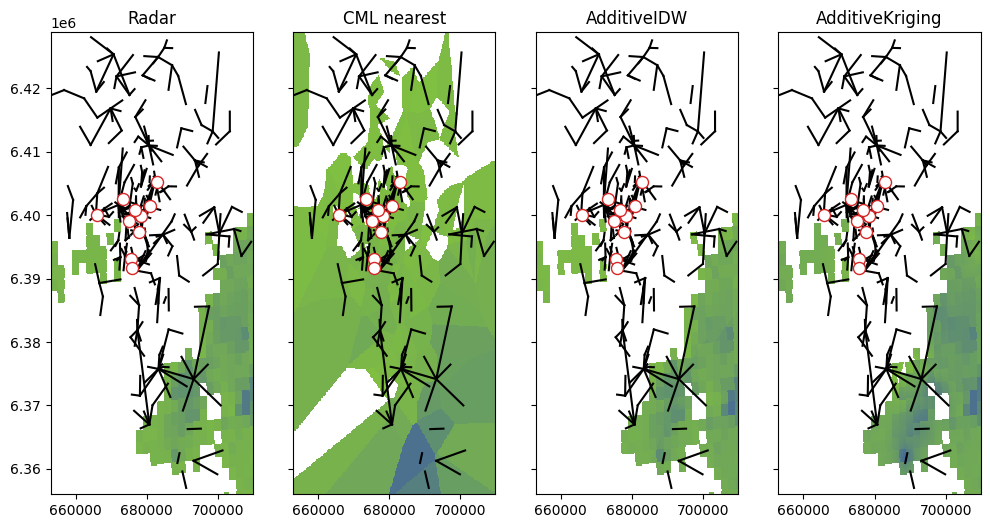

2015-07-25T12:35:00.000000000


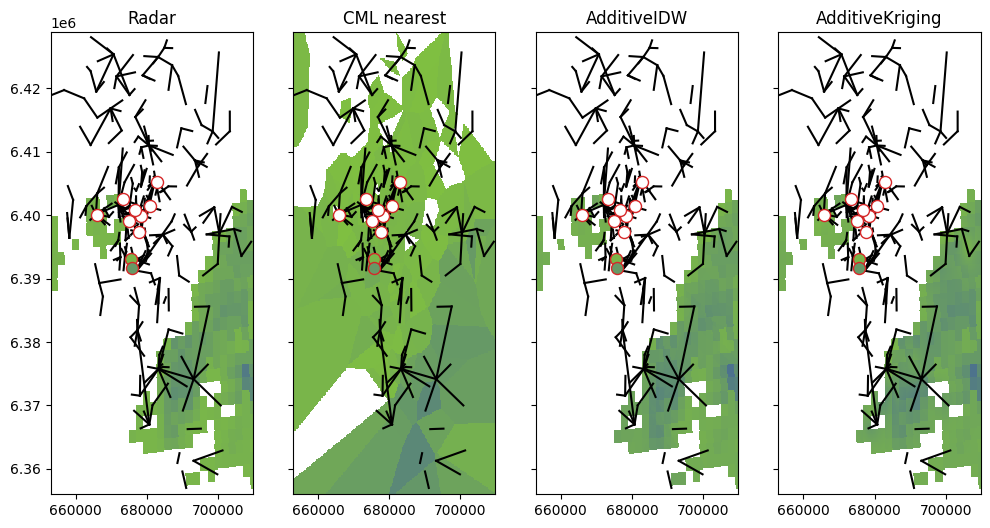

2015-07-25T12:40:00.000000000


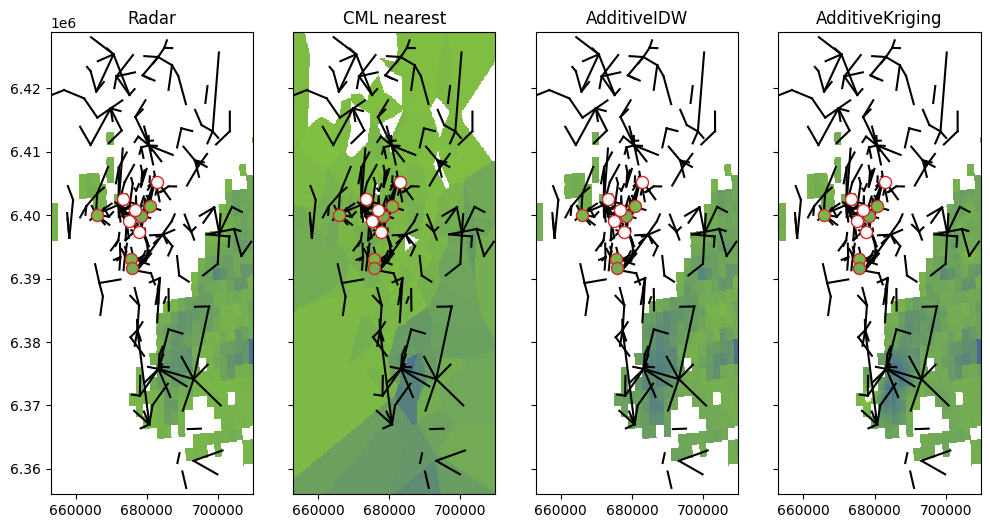

2015-07-25T12:45:00.000000000


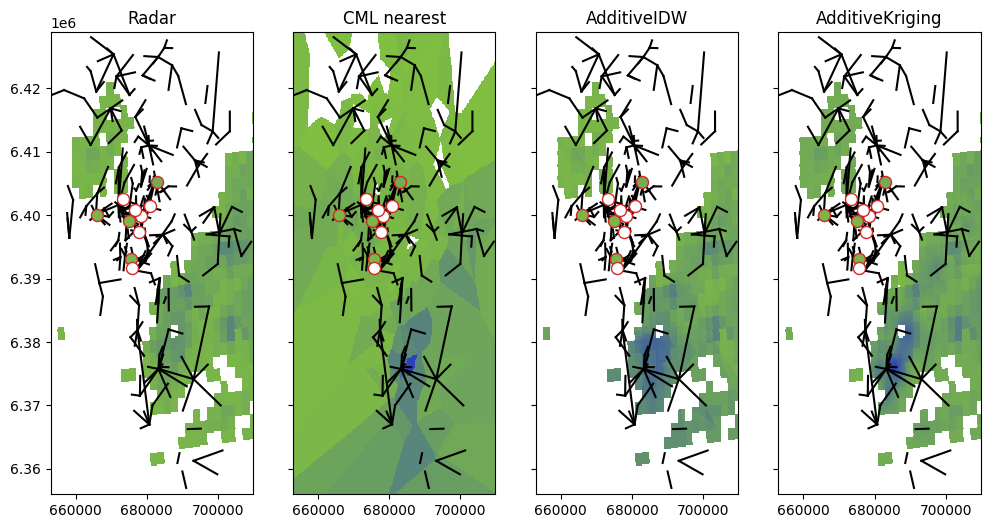

2015-07-25T12:50:00.000000000


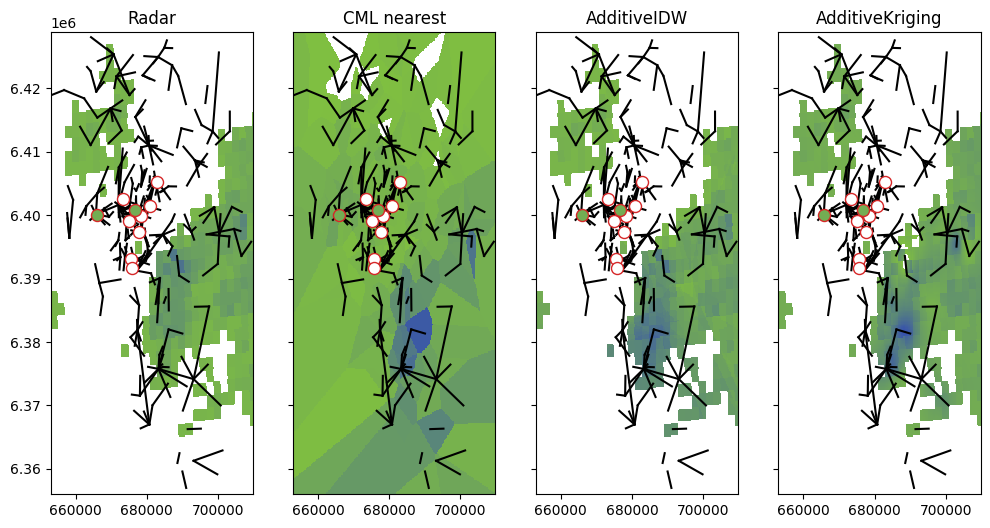

In [27]:
vmax = 2
vmin = 0
for time in ds_cmls.isel(time=slice(0, 5)).time:
    print(time.data)
    fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharey=True)
    ax[0].pcolormesh(
        ds_rad_proj.x,
        ds_rad_proj.y,
        ds_rad_proj.rainfall_amount.sel(time=time).values,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    ax[1].pcolormesh(
        ds_rad_proj.x,
        ds_rad_proj.y,
        ds_rad_proj.cml_nearest.sel(time=time).values,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    ax[2].pcolormesh(
        ds_rad_proj.x,
        ds_rad_proj.y,
        ds_rad_proj.rain_additive_idw.sel(time=time).values,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    ax[3].pcolormesh(
        ds_rad_proj.x,
        ds_rad_proj.y,
        ds_rad_proj.rain_additive_blockkriging.sel(time=time).values,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    for i in range(len(ax)):
        ax[i].set_xlim(xx.min(), xx.max())
        ax[i].set_ylim(yy.min(), yy.max())

    ax[0].set_title("Radar")
    ax[1].set_title("CML nearest")
    ax[2].set_title("AdditiveIDW")
    ax[3].set_title("AdditiveKriging")

    # PLot the CMLs position
    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "black",
                zorder=2,
            )

    # Plot points and thir values:
    for ax_i in range(len(ax)):
        for station_id in ds_gauges.station_id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(station_id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=vmin,
                vmax=vmax,
                s=75,  # markersize
                zorder=3,
            )

    plt.show()

# Compare to city gauges
# Note: Using the projected square grid in this comparison, should be replaced by GridAtPoints from poligrain as that would work for using the radar grid directly

In [28]:
# Using square grid in this version, would be replaced
aggregation = "5min"
pred_rad = []
pred_cml = []
pred_add_idw = []
pred_add_krig = []

ground = []
for station_id in ds_gauges.station_id:
    x_gauge = ds_gauges.sel(station_id=station_id).x.data
    y_gauge = ds_gauges.sel(station_id=station_id).y.data

    pred_rad.append(
        ds_rad_proj.sel(x=x_gauge, method="nearest")
        .sel(y=y_gauge, method="nearest")
        .rainfall_amount.resample(time=aggregation)
        .sum()
        .data
    )
    pred_cml.append(
        ds_rad_proj.sel(x=x_gauge, method="nearest")
        .sel(y=y_gauge, method="nearest")
        .resample(time=aggregation)
        .sum()
        .cml_nearest.data
    )

    pred_add_idw.append(
        ds_rad_proj.sel(x=x_gauge, method="nearest")
        .sel(y=y_gauge, method="nearest")
        .resample(time=aggregation)
        .sum()
        .rain_additive_idw.data
    )
    pred_add_krig.append(
        ds_rad_proj.sel(x=x_gauge, method="nearest")
        .sel(y=y_gauge, method="nearest")
        .resample(time=aggregation)
        .sum()
        .rain_additive_blockkriging.data
    )

    ground.append(
        ds_gauges.sel(station_id=station_id)
        .rainfall_amount.resample(time=aggregation)
        .sum()
        .data
    )

pred_rad = np.array(pred_rad).ravel()
pred_cml = np.array(pred_cml).ravel()

pred_add_idw = np.array(pred_add_idw).ravel()
pred_add_krig = np.array(pred_add_krig).ravel()

ground = np.array(ground).ravel()

### Including all observations

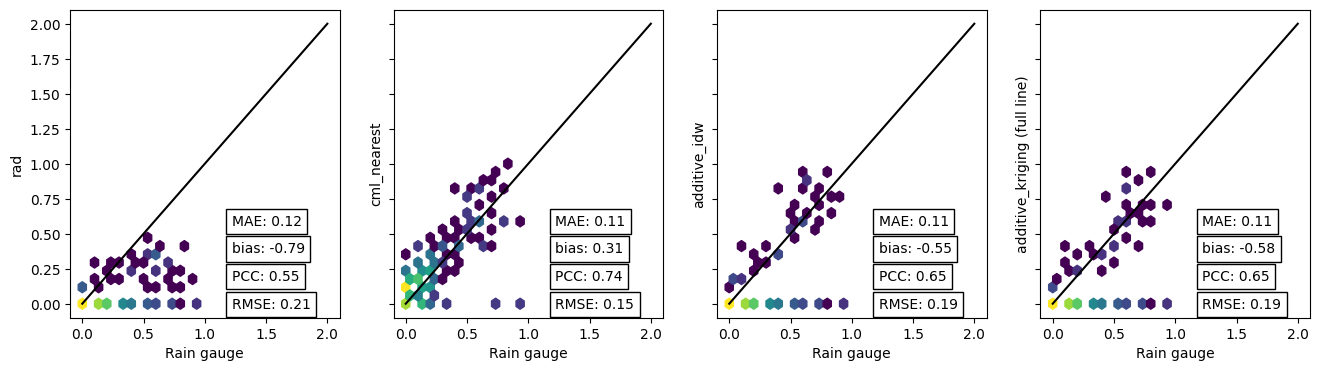

In [29]:
extent = [0, 2, 0, 2]
gridsize = 30

names = ["rad", "cml_nearest", "additive_idw", "additive_kriging (full line)"]
model = [pred_rad, pred_cml, pred_add_idw, pred_add_krig]
fig, ax = plt.subplots(1, len(names), figsize=(16, 4), sharey=True)

for i, tar in enumerate(model):
    keep = np.ones(pred_rad.shape).astype(bool)
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    # r2_score from sklrarn, not supported in mergeplg
    # ax[i].text(0.6, 0.39, 'R2: ' + str(round(r2_score(ground[keep], tar[keep]), 2)),
    #                bbox=dict(facecolor='white', edgecolor='black'),
    #                transform=ax[i].transAxes
    #               )

    ax[i].set_xlabel("Rain gauge")
    ax[i].set_ylabel(names[i])
    ax[i].plot([extent[0], extent[1]], [extent[2], extent[3]], "black")

### Including only when radar observes rain

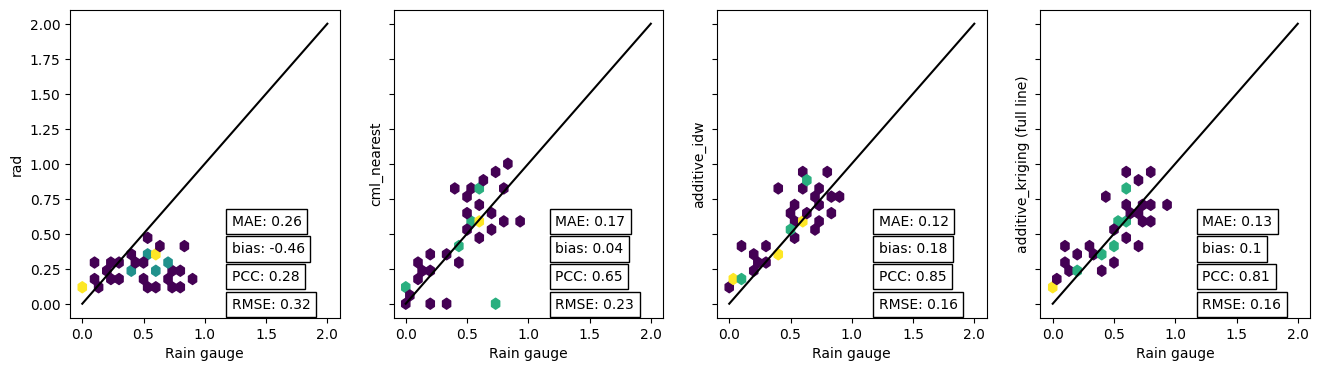

In [30]:
extent = [0, 2, 0, 2]
gridsize = 30

names = ["rad", "cml_nearest", "additive_idw", "additive_kriging (full line)"]
model = [pred_rad, pred_cml, pred_add_idw, pred_add_krig]
fig, ax = plt.subplots(1, len(names), figsize=(16, 4), sharey=True)

for i, tar in enumerate(model):
    keep = pred_rad > 0
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )

    ax[i].set_xlabel("Rain gauge")
    ax[i].set_ylabel(names[i])
    ax[i].plot([extent[0], extent[1]], [extent[2], extent[3]], "black")